In [29]:
import data_loader
import pandas as pd
import seaborn as sb
import numpy as np
init_train = data_loader.load_train_data("../data/adult.data", valid_rate=1, is_df = "True")
test = data_loader.load_test_data("../data/adult.test", is_df = "True")
train = init_train[1]

### Replacing all column indices with attribute names

We printed the dataframe and we noticed that column values were numbers, so we replaced with the attribute names for better readability.

In [30]:
col_map = ["age", "workclass", "final_weight", "education", "education_num", "marital_status", "occupation", "relationship", "race", "sex", "cap_gain", "cap_loss", "hrs_p_week","country","income"]
train.columns = col_map

### Missing Values
We now noticed that the dataset had missing values and we counted the no of missing values for every column. After finding out the columns that missing values, we removed those corresponding rows. It was approximately around 2000 and did not alter the dataset much.

In [31]:
for column in train.columns:
    su = (train[column] == ' ?').sum()
    if su > 0:
        print("Column: ",column, " Count: ",su)
train = train[((train.country != ' ?') & (train.workclass != ' ?') & (train.occupation != ' ?'))]

Column:  workclass  Count:  1836
Column:  occupation  Count:  1843
Column:  country  Count:  583


### Results Remapping

Income column is the result column. We have essentially remapped the two output values (<=50K and >50K) to binary values (0 and 1),# and put them in a new numpy array

In [32]:
train['income'] = train['income'].map({ " <=50K": 0, " >50K": 1})
#Results = np.copy(train['income'].values)
#train.drop(columns="income",inplace=True)

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## Data Visualization

<class 'pandas.core.indexes.multi.MultiIndex'>


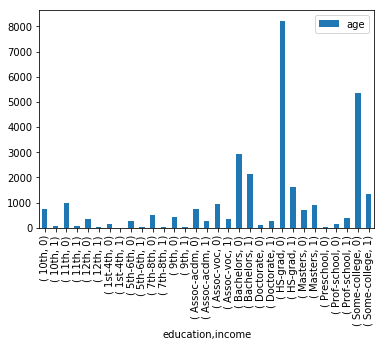

In [105]:
#train.groupby('education')['income'].plot()
#from pandas import DataFrame
temp = train.groupby(['education','income']).count()['age']
print(type(temp.index))
t_df = DataFrame(temp,index=temp.index)
t_df.plot(kind='bar',stacked=True)
#print(temp.index)
#e_df = temp[0:len(temp):2]
#print(e_df)
#te = temp.to_frame()
#print(temp)
#print(te)#print(temp['10th',0])
#o_df = temp[temp['income'] == 1]
#te.plot(x='education',y='income')

In [104]:
print(help(pd))

Help on package pandas:

NAME
    pandas

DESCRIPTION
    pandas - a powerful data analysis and manipulation library for Python
    
    **pandas** is a Python package providing fast, flexible, and expressive data
    structures designed to make working with "relational" or "labeled" data both
    easy and intuitive. It aims to be the fundamental high-level building block for
    doing practical, **real world** data analysis in Python. Additionally, it has
    the broader goal of becoming **the most powerful and flexible open source data
    analysis / manipulation tool available in any language**. It is already well on
    its way toward this goal.
    
    Main Features
    -------------
    Here are just a few of the things that pandas does well:
    
      - Easy handling of missing data in floating point as well as non-floating
        point data.
      - Size mutability: columns can be inserted and deleted from DataFrame and
        higher dimensional objects
      - Automatic an

In [38]:
help(train.plot)

Help on FramePlotMethods in module pandas.plotting._core object:

class FramePlotMethods(BasePlotMethods)
 |  FramePlotMethods(data)
 |  
 |  DataFrame plotting accessor and method
 |  
 |  Examples
 |  --------
 |  >>> df.plot.line()
 |  >>> df.plot.scatter('x', 'y')
 |  >>> df.plot.hexbin()
 |  
 |  These plotting methods can also be accessed by calling the accessor as a
 |  method with the ``kind`` argument:
 |  ``df.plot(kind='line')`` is equivalent to ``df.plot.line()``
 |  
 |  Method resolution order:
 |      FramePlotMethods
 |      BasePlotMethods
 |      pandas.core.base.PandasObject
 |      pandas.core.base.StringMixin
 |      pandas.core.accessor.DirNamesMixin
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __call__(self, x=None, y=None, kind='line', ax=None, subplots=False, sharex=None, sharey=False, layout=None, figsize=None, use_index=True, title=None, grid=None, legend=True, style=None, logx=False, logy=False, loglog=False, xticks=None, yticks=None, xlim

### Feature Cleaning:

We analyzed the dataset and found that the columns education and education number had a one-to-one mapping. Thus We have extracted this one-to-one mapping relationship into a dictionary called edu_map and removed the education column from the dataset.

In [ ]:
temp = train[['education','education_num']]
edu_map = temp.drop_duplicates().set_index('education_num').to_dict()['education']
train.drop(columns="education", inplace=True)

In [ ]:
print(train.columns)

In [ ]:
for column in train.columns:
    su = (train[column] == ' ?').sum()
    if su > 0:
        print("Column: ",column, " Count: ",su)

In [ ]:
#train.drop(columns=['workclass','occupation','country'], )
new_train = train[((train.country != ' ?') & (train.workclass != ' ?') & (train.occupation != ' ?'))]
for column in new_train.columns:
    su = (new_train[column] == ' ?').sum()
    if su > 0:
        print("Column: ",column, " Sum: ",su)

In [ ]:
print(new_train.corr())